In [5]:
import numpy as onp
import jax.numpy as np
from jax import random, vmap
from jax.config import config
from jax.scipy.special import expit as sigmoid
config.update("jax_enable_x64", True)

from scipy.optimize import minimize
from pyDOE import lhs
import matplotlib.pyplot as plt
from matplotlib import rc
from scipy.interpolate import griddata
from sklearn.metrics import confusion_matrix

from jaxbo.mcmc_models import MultifidelityGPclassifier
from jaxbo.utils import normalize, compute_w_gmm
from jaxbo.input_priors import uniform_prior

onp.random.seed(1234)

## Generate some data

In [6]:
def low_fidelity(X):
    return (0.45 + np.sin(2.2*X[:,0]*np.pi)/2.5 - X[:,1]) > 0
    
def high_fidelity(X):
    return ( 0.5 + np.sin(2.5*X[:,0]*np.pi)/3 - X[:,1]) > 0
    
def low_fidelity_boundary(X):
    return (0.45 + np.sin(2.2*X[:,0]*np.pi)/2.5)
    
def high_fidelity_boundary(X):
    return (0.5 + np.sin(2.5*X[:,0]*np.pi)/3)

In [7]:
D = 2
NL = 50 # number of low fidelity points
NH = 10 # number of high fidelity points
lb = 0.0*np.ones(D)
ub = 1.0*np.ones(D)
bounds = {'lb': lb, 'ub': ub}
p_x = uniform_prior(lb, ub)

# Training data
XL = lb + (ub - lb)*lhs(D,NL) # generate data with a Latin hypercube desing
yL = 1.0*low_fidelity(XL)

# to generate the high fidelity data we choose some points
# from both of classes in the low fidelity data
ind1 = np.where(yL > 0)[0]
ind0 = np.where(yL == 0)[0]

XH1 = XL[onp.random.choice(ind1, int(NH/2), replace = False)]
XH0 = XL[onp.random.choice(ind0, int(NH/2), replace = False)]

XH = np.concatenate([XH1, XH0], axis = 0)
yH = 1.0*high_fidelity(XH)

y = np.concatenate([yL, yH])

# Test data
nn = 50
xx = np.linspace(lb[0], ub[0], nn)
yy = np.linspace(lb[1], ub[1], nn)
XX, YY = np.meshgrid(xx, yy)
X_star = np.concatenate([XX.flatten()[:,None], YY.flatten()[:,None]], axis = 1)
y_star = 1.0*high_fidelity(X_star)

## Model setup

In [8]:
options = {'kernel': 'RBF',
           'criterion': 'CLSF', 
           'input_prior': p_x,
           'kappa': 1.0,
           'nIter': 0}
mcmc_settings = {'num_warmup': 500,
                 'num_samples': 20,
                 'num_chains': 1,
                 'target_accept_prob': 0.9}
gp_model = MultifidelityGPclassifier(options)

## Training

In [9]:
rng_key = random.PRNGKey(123)
data = {'XL': XL, 'XH': XH, 'y': y}
print('Train GP...')
key_train, key_test = random.split(rng_key)
samples = gp_model.train(data,
                         key_train,
                         mcmc_settings,
                         verbose = True)

Train GP...


sample: 100%|██████████| 520/520 [00:09<00:00, 52.95it/s, 127 steps of size 4.90e-02. acc. prob=0.87] 



                        mean       std    median      5.0%     95.0%     n_eff     r_hat
            beta_H      0.21      0.97     -0.05     -1.25      1.88     12.59      1.03
            beta_L      0.15      0.48      0.24     -0.58      0.87      8.80      1.03
          eta_H[0]     -0.37      0.50     -0.41     -0.96      0.72     25.79      1.01
          eta_H[1]     -0.66      1.34     -1.00     -2.68      1.79     28.85      0.95
          eta_H[2]      0.14      0.87      0.01     -1.40      1.24     35.74      0.95
          eta_H[3]     -0.13      0.98     -0.09     -1.64      1.69     12.90      0.99
          eta_H[4]      0.02      1.06     -0.10     -1.40      1.81     48.19      0.99
          eta_H[5]     -0.41      1.16     -0.47     -2.67      1.32     27.83      1.03
          eta_H[6]      0.01      0.83     -0.17     -1.09      1.60     33.50      0.95
          eta_H[7]     -0.42      1.34     -0.16     -2.57      1.81     13.66      0.95
          eta_H[8]  

In [10]:
# Compute predictions
rng_keys = random.split(key_test, 
                        mcmc_settings['num_samples'] * mcmc_settings['num_chains'])
kwargs = {'samples': samples,
          'batch': data,
          'bounds': bounds,
          'rng_key': key_test,
          'rng_keys': rng_keys}
mean, std = gp_model.predict(X_star, **kwargs)
acq_fn = lambda x: gp_model.acquisition(x, **kwargs)
acq = vmap(acq_fn)(X_star)
new_X = gp_model.compute_next_point_gs(X_star, **kwargs)
acc_total = np.sum(np.rint(sigmoid(mean)) == y_star)/y_star.shape[0]
print('Classification accuracy: %f%%' % (acc_total))

Classification accuracy: 0.892400%


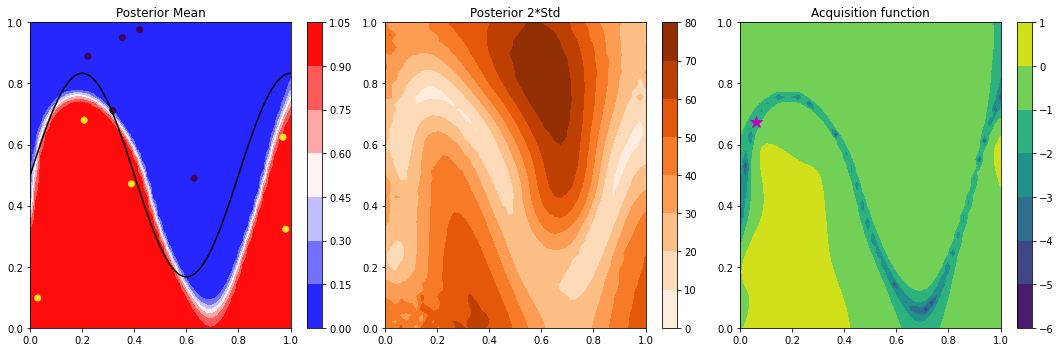

In [11]:
Mplot = mean.reshape(nn,nn)
Splot = std.reshape(nn,nn)
Aplot = acq.reshape(nn,nn)

xx = np.linspace(0, 1, 100)[:,None]

plt.figure(figsize=(15,5))
plt.subplot(1, 3, 1)
plt.contourf(XX, YY, sigmoid(Mplot), cmap=plt.get_cmap('bwr'), vmin=0, vmax=1)
plt.colorbar()
plt.scatter(XH[:,0], XH[:,1], c = yH)
plt.plot(xx , high_fidelity_boundary(xx), 'k', label = 'high-fidelity boundary')
plt.title('Posterior Mean')
plt.xlim([lb[0], ub[0]])
plt.ylim([lb[1], ub[1]])
plt.tight_layout()

plt.subplot(1, 3, 2)
plt.contourf(XX, YY, 2.0*Splot, cmap=plt.get_cmap('Oranges'), vmin=0)
plt.colorbar()
# plt.scatter(X[:,0], X[:,1], c = y)
plt.title('Posterior 2*Std')
plt.xlim([lb[0], ub[0]])
plt.ylim([lb[1], ub[1]])
plt.tight_layout()

plt.subplot(1, 3, 3)
plt.contourf(XX, YY, Aplot)
plt.plot(new_X[0,0], new_X[0,1], 'm*', ms = 12)
plt.colorbar()
# plt.scatter(X[:,0], X[:,1], c = y)
plt.title('Acquisition function')
plt.xlim([lb[0], ub[0]])
plt.ylim([lb[1], ub[1]])
plt.tight_layout()